# Model Training With Experimental 
by Victor Hugo Flores Muñoz

In [1]:
from IPython import display
from tensorflow.python.ops.numpy_ops import np_config
from zernike import RZern
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import time

2024-09-26 10:40:27.071672: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 10:40:27.114515: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 10:40:27.114549: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 10:40:27.114582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 10:40:27.123118: I tensorflow/core/platform/cpu_feature_g

Define Helpers

In [2]:
def normaliza(A):
    mask = np.isnan(A)
    B = np.nan_to_num(A, nan=0)
    C = (B - B.min())/(B.max() - B.min()) * 2 - 1
    C[mask] = 0.0
    return C

def normaliza_pos(A):
    mask = np.isnan(A)
    B = np.nan_to_num(A, nan=0)
    C = (B - B.min())/(B.max() - B.min())
    C[mask] = 0.0
    return C

def generate_mask(reference):
    mask = np.isnan(reference)
    mask = np.logical_not(mask)
    return mask

def json_to_dict(path, destination_dict):
    loaded_dict = json.load(open(path, 'r'))
    for key in loaded_dict.keys():
        destination_dict[key] = loaded_dict[key]

The generator uses this order:
$$ [ Z_0^0, Z_1^1, Z_1^{-1}, Z_2^0, Z_2^{-2}, Z_2^2 ] $$

In [3]:
HEIGHT = 256
WIDTH = 256
cart = RZern(2)
ddx = np.linspace(-1.0, 1.0, WIDTH)
ddy = np.linspace(-1.0, 1.0, HEIGHT)
xv, yv = np.meshgrid(ddx, ddy)
cart.make_cart_grid(xv, yv)
num_coef = cart.nk
print("Numero de coeficientes: ", num_coef)
Phi = cart.eval_grid(np.array([0,1,0,0,0,0]), matrix=True)
MASK = generate_mask(Phi)

Numero de coeficientes:  6


## 1. Preparing the Experimental Dataset
This dataset uses the following order:
$$ [ Z_0^0, Z_1^{-1}, Z_1^1, Z_2^0, Z_2^{-2}, Z_2^2 ] $$

Load images without complements

In [4]:
experimental_path = '/mnt/DATOS2/jvargas/Sernikes/Final/Zernikes-20240625T113115Z-001/Zernikes/Train/'
fnames = os.listdir(experimental_path)
clean_fnames = [fname for fname in fnames if '_c' not in fname]
clean_fnames.sort()
len(clean_fnames)

5000

Load labels from json files

In [5]:
path_combinacion = '/mnt/DATOS2/jvargas/Sernikes/Final/Zernikes-20240625T113115Z-001/Zernikes/Json/Zernikes_coef_combinacion.json'
path_puros = '/mnt/DATOS2/jvargas/Sernikes/Final/Zernikes-20240625T113115Z-001/Zernikes/Json/Zernikes_coef_puros.json'
path_random = '/mnt/DATOS2/jvargas/Sernikes/Final/Zernikes-20240625T113115Z-001/Zernikes/Json/Zernikes_coef_random.json'
mega_json = {}
json_to_dict(path_combinacion, mega_json)
json_to_dict(path_puros, mega_json)
json_to_dict(path_random, mega_json)
print(len(mega_json))

5000


Create training variables

In [6]:
X = []
y = []
for fname in clean_fnames:
    X.append(cv2.imread(experimental_path + fname, cv2.IMREAD_GRAYSCALE) / 255.0)
    y.append(mega_json[fname])
print("Loaded images: ", len(X))
print("Loaded labels: ", len(y))
X = np.array(X)
y = np.array(y)
print("X shape: ", X.shape) 
print("y shape: ", y.shape)

Loaded images:  5000
Loaded labels:  5000
X shape:  (5000, 256, 256)
y shape:  (5000, 6)


Swap columns

In [7]:
def swap_columns(arr, frm, to):
    arr[:,[frm, to]] = arr[:,[to, frm]]

swap_columns(y, 1, 2)

Check the label asignation

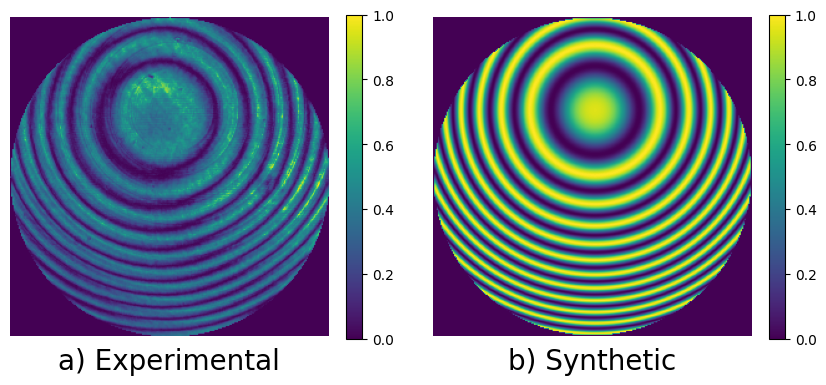

In [8]:
def generate_zernike_cos(coef, normalize=True):
    Phi = cart.eval_grid(coef, matrix=True)
    Phi = np.cos(Phi)
    if normalize:
        Phi = normaliza_pos(Phi)
    return Phi

def plot_real_and_ideal(index, normalize=True):
    coef = y[index]
    Phi = generate_zernike_cos(coef, normalize)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(normaliza_pos(X[index]))
    # plt.title(f'{np.round(y[200], decimals=2)}')
    plt.title("a) Experimental", fontdict={'fontsize': 20}, y=-0.13)
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(Phi)
    # plt.title(f'{np.round(y[200], decimals=2)}')
    plt.title("b) Synthetic", fontdict={'fontsize': 20}, y=-0.13)
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    plt.show()

sample = 200
plot_real_and_ideal(sample, normalize=True)

### 1.1 Dataset Generation

In [9]:
from sklearn.utils import shuffle

NUM_SAMPLES = len(X)

num_samples_train = round(NUM_SAMPLES * .9)
X, y = shuffle(X, y)
X_train = np.expand_dims(X[:num_samples_train], axis=3)
y_train = y[:num_samples_train]
X_test = np.expand_dims(X[num_samples_train:], axis=3)
y_test = y[num_samples_train:]
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (4500, 256, 256, 1)
X_test shape:  (500, 256, 256, 1)


Create train, test and validation datasets

In [10]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)
validation_split = 0.1
num_samples = len(train_dataset)
num_train = round(num_samples * (1 - validation_split))
train_ds = train_dataset.take(num_train).batch(BATCH_SIZE)
val_dataset = train_dataset.skip(num_train).batch(BATCH_SIZE)

2024-09-26 10:40:57.487289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22447 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-09-26 10:40:57.487893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22447 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:5e:00.0, compute capability: 8.6
2024-09-26 10:40:57.488364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22447 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6
2024-09-26 10:40:57.488872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21971 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

## 2. Load Models
Load the models trained with synthetic patterns.

### 2.1 Loss and Optimizers

In [11]:
loss_object = tf.keras.losses.MeanSquaredError()
loss_object_zernike = tf.keras.losses.MeanAbsoluteError()
loss_object_phase = tf.keras.losses.MeanAbsoluteError()

autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
zernike_decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

BETA = 100
ALPHA = 1
LAMBDA = 10

def ae_loss(y_true, y_pred):
    return BETA * loss_object(y_true, y_pred)


def generate_zernike(coef, normalize=True):
    Phi = cart.eval_grid(coef, matrix=True)
    if normalize:
        Phi = normaliza_pos(Phi)
    return Phi

def zernike2phi(coef):
    Phi = tf.map_fn(
        lambda x: generate_zernike(x, normalize=False),
        coef
    )
    B = np.nan_to_num(Phi, nan=0)
    return B

def zernike2cos(coef):
    Phi = tf.map_fn(
        lambda x: generate_zernike(x, normalize=False),
        coef
    )
    Phi = tf.math.cos(Phi)
    Phi = tf.map_fn(lambda x: normaliza_pos(x), Phi)
    return Phi

def phase_loss(y_true, y_pred):
    phi = zernike2phi(y_true)
    hat_phi = zernike2phi(y_pred)
    return ALPHA * loss_object_phase(phi, hat_phi)

def cos_loss(y_true, y_pred):
    phi = zernike2cos(y_true)
    hat_phi = zernike2cos(y_pred)
    return LAMBDA * loss_object_phase(phi, hat_phi)

def zernike_loss(y_true, y_pred):
    return ALPHA * loss_object_zernike(y_true, y_pred)

def zernike2gradient(coef):
    Phi = tf.map_fn(
        lambda x: generate_zernike(x, normalize=False),
        coef
    )
    Phi = tf.convert_to_tensor(
        np.expand_dims(
            np.nan_to_num(Phi), 
            axis=3
        )
    )
    dx, dy = tf.image.image_gradients(Phi)
    return dx, dy

def grad_loss(y_true, y_pred):
    dx_true, dy_true = zernike2gradient(y_true)
    dx_pred, dy_pred = zernike2gradient(y_pred)
    return LAMBDA * (0.5*loss_object(dx_true, dx_pred) + 0.5*loss_object(dy_true, dy_pred))

def total_zernike_loss(y_true, y_pred):
    return phase_loss(y_true, y_pred) + grad_loss(y_true, y_pred) + zernike_loss(y_true, y_pred)

def model_loader(path, optimizer, loss):
    model = tf.keras.models.load_model(path, compile=False)
    model.compile(optimizer=optimizer, 
                  loss=loss)
    return model

def generate_images(models, test_input, tar):

    encoder = models[0]
    decoder = models[1]
    zernike_decoder = models[2]

    encoded_image = encoder(test_input, training=True)
    prediction = normaliza_pos(decoder(encoded_image, training=True))
    zernikes = zernike_decoder(encoded_image, training=True)
    
    got = np.nan_to_num(
        normaliza_pos(generate_zernike(tar[0].numpy(), normalize=False)),
        nan=0
    )
    
    generated_zernike = np.nan_to_num(
        normaliza_pos(generate_zernike(zernikes[0].numpy(), normalize=False)), 
        nan=0
    )
    error = np.sqrt(np.abs(got - generated_zernike))

    plt.figure(figsize=(25,15))

    display_list = [
        normaliza_pos(test_input[0]), 
        normaliza_pos(prediction[0]), 
        got, 
        generated_zernike, 
        error
    ]

    title = [
        r'a) $I_{exp}$', 
        r'b) $\hat I$', 
        r'c) $\phi$',
        r'd) $\hat \phi$',
        r'e) RMSE'
    ]
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i], fontdict={'fontsize': 20}, y=-0.15)
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i])
        plt.colorbar(fraction=0.046)
        plt.axis('off')

    plt.show()

### 2.2 Load Trained Models

In [12]:
encoder = model_loader('../models/ae_encoder.h5',
                       autoencoder_optimizer,
                       ae_loss)
decoder = model_loader('../models/ae_decoder.h5',
                       autoencoder_optimizer,
                       ae_loss)
zernike_decoder = model_loader('../models/zae_zernike_decoder.h5',
                              zernike_decoder_optimizer,
                              total_zernike_loss)

/home/jvargas/miniconda3/envs/zernike/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## 3. Fine Tunning Experimental Patterns

2024-09-26 10:41:12.810644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


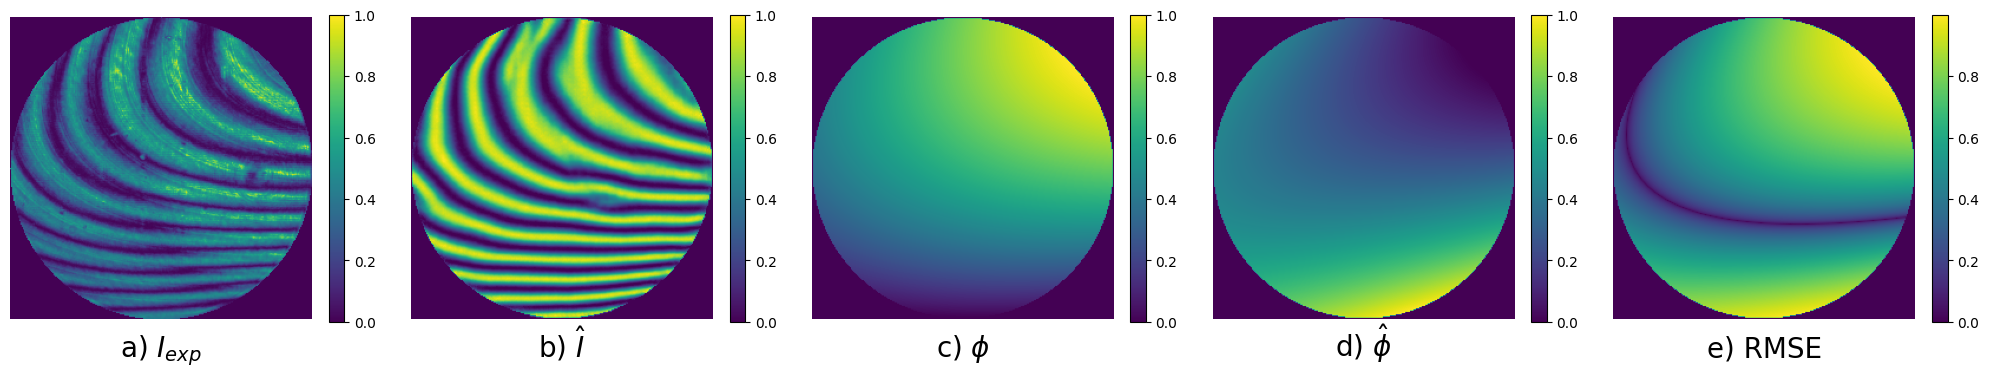

In [13]:
for example_input, example_target in test_dataset.take(1):
    generate_images([encoder, decoder, zernike_decoder], example_input, example_target)

## 3.1 Training Step and Fit Functions

In [14]:
@tf.function()
def train_step_zae(input_image, target):
    with tf.GradientTape() as zernike_decoder_tape:
        encoded_image = encoder(input_image)
        zernikes = zernike_decoder(encoded_image, training=True)

        # Loss calculation
        zernike_decoder_loss = zernike_loss(target, zernikes)
        estimated_phase_loss = phase_loss(target, zernikes)
        estimated_grad_loss = grad_loss(target, zernikes)

        # Total loss
        total_zernike_decoder_loss = zernike_decoder_loss +\
                                     estimated_phase_loss + \
                                     estimated_grad_loss

    zernike_decoder_gradients = zernike_decoder_tape.gradient(
        total_zernike_decoder_loss, 
        zernike_decoder.trainable_variables
    )
    
    zernike_decoder_optimizer.apply_gradients(zip(
        zernike_decoder_gradients, 
        zernike_decoder.trainable_variables
    )) 

    return [zernike_decoder_loss, 
            estimated_phase_loss, 
            estimated_grad_loss]

@tf.function()
def validation_step_zae(input_image, target):
    encoded_image = encoder(input_image)
    zernikes = zernike_decoder(encoded_image, training=False)
     # Loss calculation
    zernike_decoder_loss = zernike_loss(target, zernikes)
    estimated_phase_loss = phase_loss(target, zernikes)
    estimated_grad_loss = grad_loss(target, zernikes)

    # Total loss
    total_zernike_decoder_loss = zernike_decoder_loss +\
                                    estimated_phase_loss + \
                                    estimated_grad_loss
    return total_zernike_decoder_loss

def plot_graphs_zae(record, epoch):
    x = range(epoch)
    fig, ax1 = plt.subplots(figsize=(10,4))
    color = 'tab:red'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Training loss', color=color)
    ax1.plot(x, record['total_zernike_decoder_loss_train'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation loss', color=color)
    ax2.plot(x, record['total_zernike_decoder_loss_val'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()


def fit_zae(train_ds, val_ds, test_ds, epochs):
    tf.compat.v1.enable_eager_execution()

    record = {
        'zernike_decoder_loss': [],
        'estimated_phase_loss': [],
        'estimated_grad_loss': [],
        'total_zernike_decoder_loss_train': [], 
        'total_zernike_decoder_loss_val': [], 
        'time': []
    }

    example_input, example_target = next(iter(test_ds.take(1)))
    
    lowest_loss = 1000
    saved_epoch = 0
    for epoch in range(epochs):

        start = time.time()
        print("Epoch: ", epoch + 1)

        n = 0
        for input_image, target in train_ds:
            zernike_decoder_loss = train_step_zae(input_image,
                                                  target)
            if n % 10 == 0:
                print('··', end='')
            n += 1

        accumulated_loss_val = 0
        for input_image, target in val_ds:
            zernike_decoder_loss_val = validation_step_zae(input_image, 
                                                           target)
            accumulated_loss_val += zernike_decoder_loss_val.numpy()
        accumulated_loss_val /= len(val_ds)
        
        display.clear_output(wait=True)
        generate_images([encoder, decoder, zernike_decoder], 
                        example_input, 
                        example_target)
        
        record['zernike_decoder_loss'].append(zernike_decoder_loss[0].numpy())
        record['estimated_phase_loss'].append(zernike_decoder_loss[1].numpy())
        record['estimated_grad_loss'].append(zernike_decoder_loss[2].numpy())
        record['total_zernike_decoder_loss_train'].append(
            zernike_decoder_loss[0].numpy() + \
            zernike_decoder_loss[1].numpy() + \
            zernike_decoder_loss[2].numpy()
        )
        record['total_zernike_decoder_loss_val'].append(accumulated_loss_val)
        delta_time = time.time() - start
        record['time'].append(delta_time)

        plot_graphs_zae(record, epoch + 1)

        print("Time taken: ", delta_time)
        print("Zernike Decoder Loss: ", zernike_decoder_loss[0].numpy())
        print("Estimated Phase Loss: ", zernike_decoder_loss[1].numpy())
        print("Estimated Gradient Loss: ", zernike_decoder_loss[2].numpy())
        print("Total Zernike Decoder Loss Training: ", 
              zernike_decoder_loss[0].numpy() + \
              zernike_decoder_loss[1].numpy() + \
              zernike_decoder_loss[2].numpy())
        print("Total Zernike Decoder Loss Validation: ", accumulated_loss_val)
        
        # if epoch > round(epochs * 0.8):
        if record['total_zernike_decoder_loss_train'][-1] < lowest_loss:
            zernike_decoder.save('../saved_models/zae_zernike_decoder_experimental_temp.h5')
            saved_epoch = epoch + 1
            lowest_loss = record['total_zernike_decoder_loss_train'][-1]
        
        print("Saved model on epoch: ", saved_epoch)
        print("Total Zernike Decoder Loss: ", lowest_loss)

    return record

### 3.2 Fine Tunning

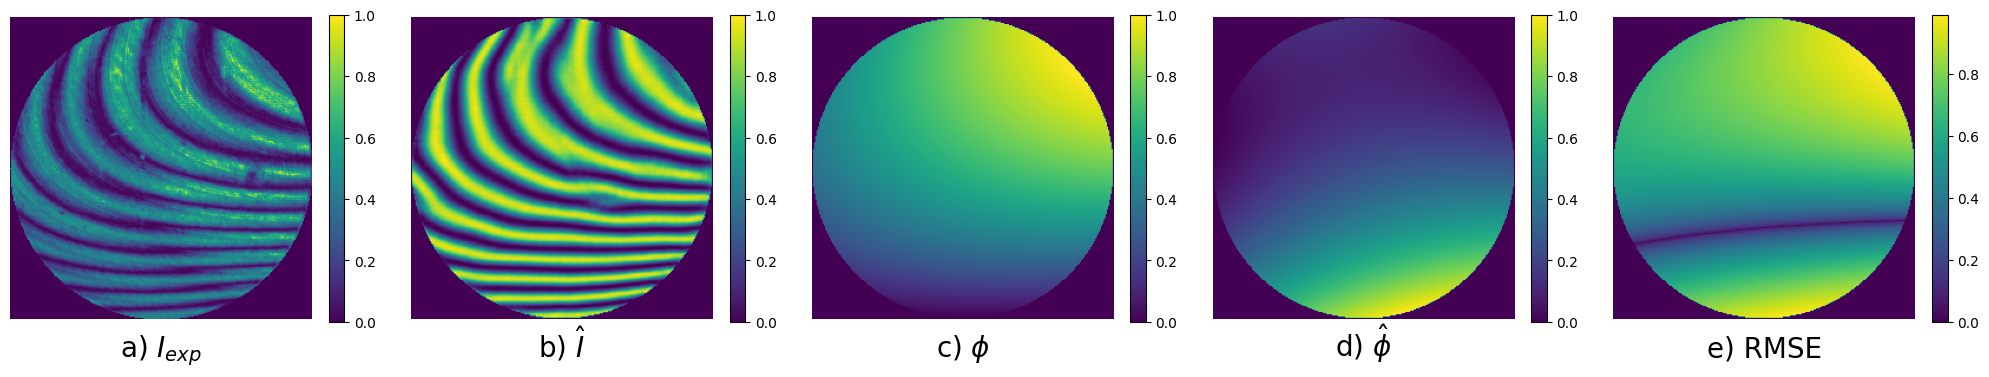

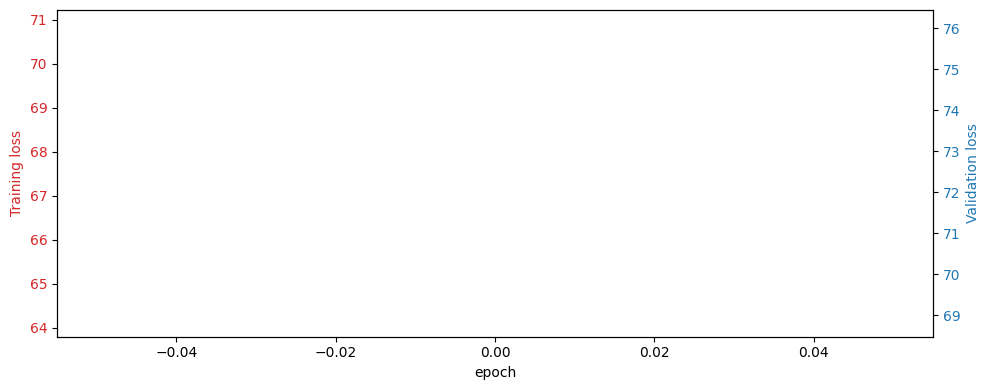

Time taken:  108.90106129646301
Zernike Decoder Loss:  4.115647
Estimated Phase Loss:  8.550694
Estimated Gradient Loss:  54.8386
Total Zernike Decoder Loss Training:  67.504944
Total Zernike Decoder Loss Validation:  72.45774459838867
Saved model on epoch:  1
Total Zernike Decoder Loss:  67.504944


/home/jvargas/miniconda3/envs/zernike/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
np_config.enable_numpy_behavior()
tf.config.run_functions_eagerly(True)
EPOCHS = 1
record = fit_zae(train_ds, val_dataset, test_dataset, epochs=EPOCHS)

## 4. Results

### 4.1 Save model and metrics

In [16]:
os.makedirs('../data', exist_ok=True)

with open('../data/record.pkl', 'wb') as f:
    pickle.dump(record, f)

# zernike_decoder.save('../models/zae_zernike_decoder_experimental.h5')

### 4.2 Evaluation of Test Dataset

In [17]:
zautoencoder = tf.keras.models.Model(
    inputs=encoder.inputs, 
    outputs=zernike_decoder(encoder.outputs)
)
zautoencoder.compile(optimizer=zernike_decoder_optimizer, 
                     loss=total_zernike_loss)
zautoencoder.evaluate(X_test, y_test)

/home/jvargas/miniconda3/envs/zernike/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 [==============================] - 11s 631ms/step - loss: 79.8486


79.84858703613281

### 4.3 Sample Results

2/2 [==============================] - 0s 55ms/step


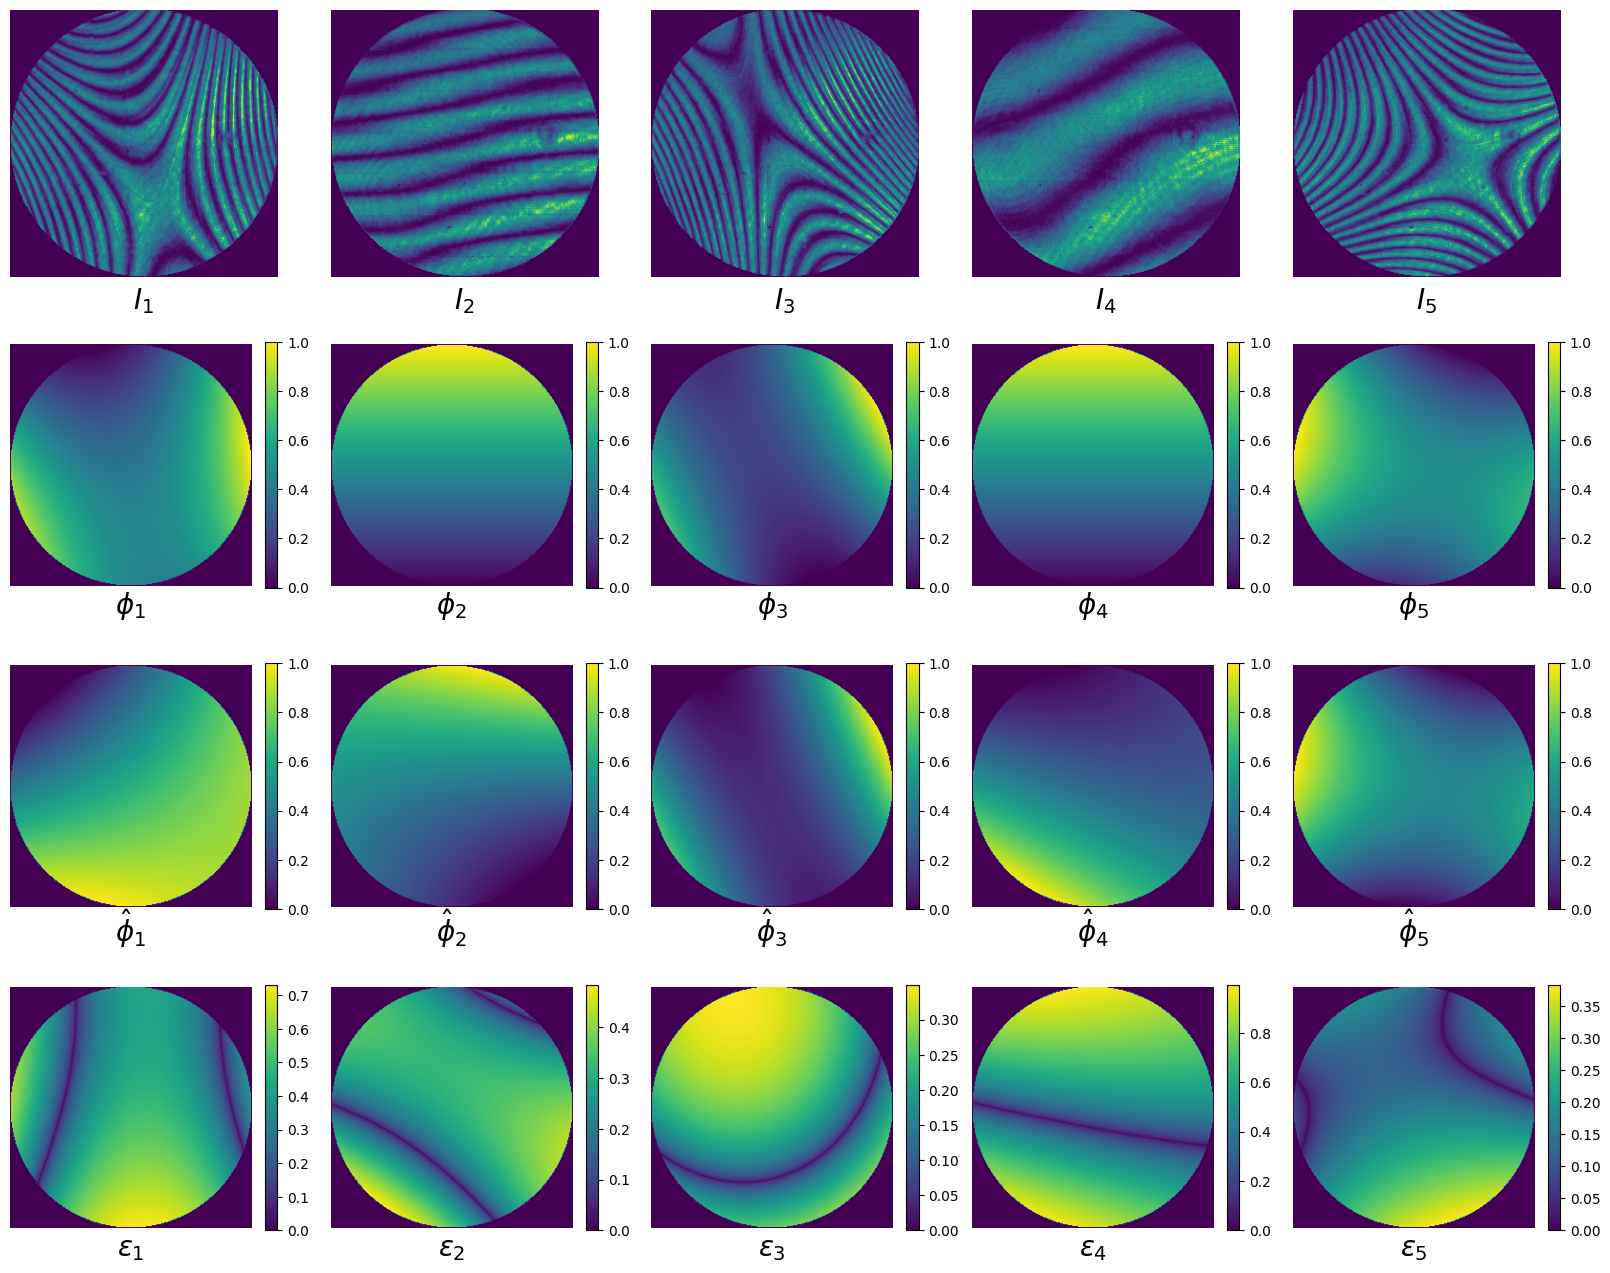

In [18]:
def error_estimator(y_true, y_pred):
    return np.sqrt(np.abs(y_true - y_pred))

samples = [1, 2, 3, 4, 5]
example_input, example_target = next(iter(train_ds.take(100)))
zernike_coefs = zautoencoder.predict(example_input)
generated_zernike = zernike2phi(zernike_coefs)
real_zernike = zernike2phi(example_target)
plt.figure(figsize=(20, 16))
for i in range(5):
    y_true = normaliza_pos(real_zernike[samples[i]])*MASK
    y_pred = normaliza_pos(generated_zernike[samples[i]])*MASK
    error = error_estimator(y_true, y_pred)*MASK
    experimental_pattern = example_input[samples[i]]
    plt.subplot(4, 5, i + 1)
    plt.imshow(experimental_pattern, origin='lower')
    # plt.colorbar(fraction=0.046)
    plt.axis('off')
    plt.title(r'$I_{}$'.format(i + 1), fontdict={'fontsize': 20}, y=-0.15)
    plt.subplot(4, 5, i + 6)
    plt.imshow(y_true, origin='lower')
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    plt.title(r'$\phi_{}$'.format(i + 1), fontdict={'fontsize': 20}, y=-0.15)
    plt.subplot(4, 5, i + 11)
    plt.imshow(y_pred, origin='lower')
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    plt.title(r'$\hat\phi_{}$'.format(i + 1), fontdict={'fontsize': 20}, y=-0.18)
    plt.subplot(4, 5, i + 16)
    plt.imshow(error, origin='lower')
    plt.colorbar(fraction=0.046)
    plt.axis('off')
    plt.title(r'$\epsilon_{}$'.format(i + 1), fontdict={'fontsize': 20}, y=-0.15)
plt.show()